In [1]:
import gym
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
## 策略网络
## 输入状态，输出选择每个动作的概率
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Softmax())
    def forward(self,x):
        return self.fc2(self.fc1(x))
    
## 价值网络
## 输入状态，输出状态平均的价值
class ValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,x):
        return self.fc2(self.fc1(x))

In [12]:
class Actor_Critic():
    def __init__(self,state_dim,hidden_dim,action_dim,gamma,actor_lr,critic_lr,device):
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.critic=ValueNet(state_dim,hidden_dim).to(device)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.device=device
        self.gamma=gamma
    def take_action(self,state):
        state=torch.FloatTensor(state).unsqueeze(0).to(device)
        prod=self.actor(state)
        action_dist=torch.distributions.Categorical(prod)
        action=action_dist.sample()
        return action.item()
    
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target=rewards+self.gamma*self.critic(next_states)*(1-dones)
        td_delta=td_target-self.critic(states)
        log_prods=torch.log(self.actor(states).gather(1,actions))
        
        actor_loss=torch.mean(-log_prods*td_delta.detach())
        
        critic_loss=torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

In [13]:
actor_lr = 1e-3
critic_lr = 1e-2
epochs = 1000
hidden_dim = 128
gamma = 0.98
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = Actor_Critic(state_dim, hidden_dim, action_dim,gamma,actor_lr, critic_lr,device)
return_list=[]                                                                       
for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1)and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append((done1 or done2))
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
    
                

iter 9: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s, epoch=1098, return=500.000]


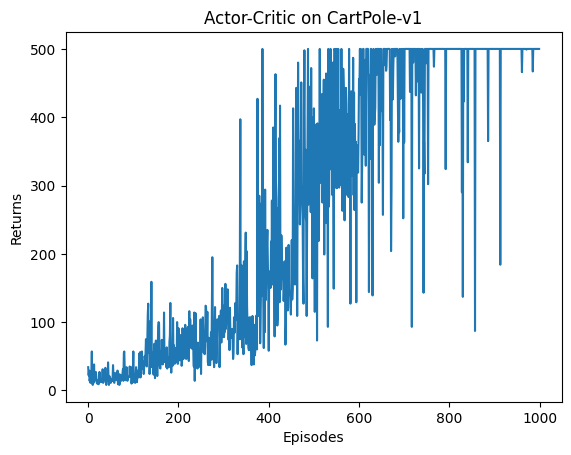

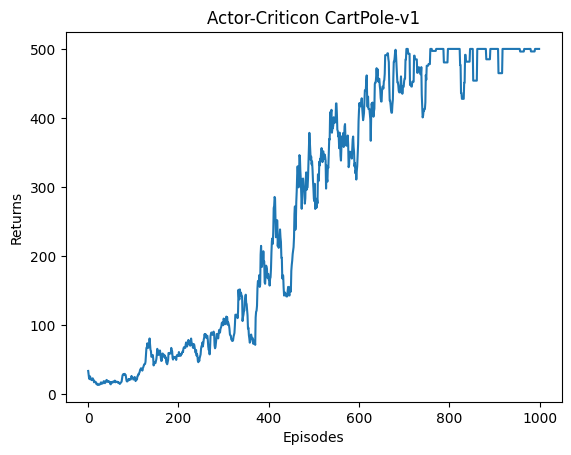

In [15]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Criticon {}'.format(env_name))
plt.show()